# Actividad evaluable del módulo 3: Clasificación del conjunto de datos MNIST

Ahora que hemos aprendido a utilizar todo lo que nos ofrece PyTorch, vamos a clasificar un conjunto de datos específico. Más concretamente, construiremos un clasificador para el conjunto de datos MNIST de cifras escritas a mano (https://en.wikipedia.org/wiki/MNIST_database). Este conjunto contiene decenas de miles de cifras entre 0 y 9 escritas a mano, y se suele utilizar a menudo para entrenar algoritmos de *machine learning*. En esta actividad, le proporcionaremos código básico para cargar los datos y deberá construir una red neuronal profunda entrenada con este conjunto de datos. Le animamos a reutilizar el código que haya escrito o visto en los cuadernos anteriores.

In [17]:
import torch
import torch.nn as nn
import torchvision.datasets
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import time, copy

Primero, cargaremos el conjunto de datos MNIST. PyTorch ofrece una serie de funciones integradas para cargar conjuntos de imágenes de uso frecuente, entre ellos MNIST.

In [18]:
# Estas transformaciones se aplicarán a todos los puntos de datos. En este ejemplo, queremos transformarlos
# todos al tipo de datos Tensor
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize([0.5], [0.5])])
mnist_train = torchvision.datasets.MNIST('', train=True, transform = transform, download=True)
# Vamos a dividir el conjunto de datos de entrenamiento en entrenamiento y validación
mnist_train, mnist_val = torch.utils.data.random_split(mnist_train, [50000, 10000])
mnist_test = torchvision.datasets.MNIST('', train=False, transform = transform, download=True)

In [19]:
# Crearemos DataLoaders, igual que hicimos antes, y el tamaño de los lotes será de 100
batch_size = 100
dataloaders = {'train': DataLoader(mnist_train, batch_size=batch_size),
               'val': DataLoader(mnist_val, batch_size=batch_size),
               'test': DataLoader(mnist_test, batch_size=batch_size)}

dataset_sizes = {'train': len(mnist_train),
                 'val': len(mnist_val),
                 'test': len(mnist_test)}
print(f'dataset_sizes = {dataset_sizes}')

dataset_sizes = {'train': 50000, 'val': 10000, 'test': 10000}


In [20]:
# Una pista: En el cuaderno "Módulo 3: Introducción a PyTorch",
# la red que creamos requería que los datos de input tuvieran la forma Nx1, donde N es el número de atributos.
# El conjunto de datos MNIST tiene una forma de 28 x 28, porque se trata de imágenes.
# Utilice este fragmento de código a medida que vaya iterando los puntos de datos del conjunto
# para aplanarlos, de manera que tengan un tamaño de 784 x 1 y se puedan utilizar con los modelos que ya hemos diseñado.

# Este bucle solo itera por los puntos de datos de entrenamiento.
# En el cuaderno anterior
# phases = ["train", "val", "test"]

# for phase in phases:
    # for inputs, labels in dataloaders[phase]:
        # Esto aplanará todos los lotes para que tengan el tamaño correcto
        # inputs = inputs.view(inputs.shape[0],-1)
        # print(inputs.shape)


In [36]:
# Modelo de clasificación simple de dos capas ocultas
class SimpleClassifier2Layer(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, num_classes, dropout):
        super(SimpleClassifier2Layer, self).__init__()
        self.dropout = nn.Dropout(dropout) # dropout rate
        self.layers = nn.Sequential(
            nn.Linear(input_size, hidden_size1),
            nn.ReLU(),
            nn.Linear(hidden_size1, hidden_size2),
            nn.ReLU(),
            nn.Linear(hidden_size2, num_classes),
        )

    def forward(self, x):
        return self.layers(x)

# Modelo de clasificación simple de tres capas ocultas
class SimpleClassifier3Layer(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, hidden_size3, num_classes, dropout):
        super(SimpleClassifier3Layer, self).__init__()
        self.dropout = nn.Dropout(dropout) # dropout rate
        self.layers = nn.Sequential(
            nn.Linear(input_size, hidden_size1),
            nn.ReLU(),
            nn.Linear(hidden_size1, hidden_size2),
            nn.ReLU(),
            nn.Linear(hidden_size2, hidden_size3),
            nn.ReLU(),
            nn.Linear(hidden_size3, num_classes),
        )

    def forward(self, x):
        return self.layers(x)

In [39]:
# Configuración del dispositivo (si es posible, entrenar el modelo en la GPU, el proceso será mucho más rápido)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')
print("device:", device)

# Hiperparámetros

# Arquitectura del modelo
input_size = 784
hidden_size1 = 128
hidden_size2 = 64
hidden_size3 = 32
num_classes = 10
dropout = .25

# Parámetros de entrenamiento externos
learning_rate = 0.001
num_epochs = 10

device: cuda


In [30]:
def train_model(model, dataloaders, dataset_sizes, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict()) # Los mejores pesos se deben guardar por separado
    best_acc = 0.0
    best_epoch = 0

    # Cada ciclo tiene una fase de entrenamiento, una de validación y una de prueba
    phases = ['train', 'val', 'test']
    
    # Hacer un seguimiento de la evolución de la pérdida y la precisión durante el entrenamiento
    training_curves = {}
    for phase in phases:
        training_curves[phase+'_loss'] = []
        training_curves[phase+'_acc'] = []
    
    for epoch in range(num_epochs):
        print(f'\nEpoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        for phase in phases:
            if phase == 'train':
                model.train()  # Configurar el modelo en el modo de entrenamiento
            else:
                model.eval()   # Configurar el modelo en el modo de evaluación

            running_loss = 0.0
            running_corrects = 0

            # Iterar con los datos
            for inputs, labels in dataloaders[phase]:
                # Importante: se deben aplanar todos los puntos de datos
                # para que sean compatibles con el modelo

                inputs = inputs.view(inputs.shape[0],-1)
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Poner a 0 los gradientes de los parámetros
                optimizer.zero_grad()

                # Método forward
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, predictions = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Método backward y actualización de los pesos solo si está en la fase de entrenamiento
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Estadísticas
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(predictions == labels.data)
 
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            training_curves[phase+'_loss'].append(epoch_loss)
            training_curves[phase+'_acc'].append(epoch_acc.cpu())

            print(f'{phase:5} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Hacer una copia profunda del modelo si se ha alcanzado la mejor precisión
            if phase == 'val' and epoch_acc > best_acc:
                best_epoch = epoch
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

    time_elapsed = time.time() - since
    print(f'\nTraining complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f} at epoch {best_epoch}')

    # Cargar los mejores pesos del modelo
    model.load_state_dict(best_model_wts)
    
    return model, training_curves

In [40]:
# ESCRIBA AQUÍ EL CÓDIGO

modelo = SimpleClassifier3Layer(input_size, hidden_size1, hidden_size2, hidden_size3, num_classes, dropout)

# pérdida y optimizador ("loss and optimizer") =
# criterio ("criterion") = 
criterion = nn.CrossEntropyLoss() # Aplicar la función de pérdida CrossEntropyLoss para la clasificación
# optimizador ("optimizer") = 
optimizer = torch.optim.Adam(modelo.parameters(), lr=learning_rate, weight_decay=0.01)

# Planificador ("scheduler") = 
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

modelo.cuda()
# Entrenar el modelo y guardar los resultados del entrenamiento
modelo, training_curves = train_model(modelo, dataloaders, dataset_sizes, 
                                     criterion, optimizer, scheduler, num_epochs=num_epochs)


Epoch 1/10
----------
train Loss: 0.5888 Acc: 0.8287
val   Loss: 0.3542 Acc: 0.9071
test  Loss: 0.3465 Acc: 0.9043

Epoch 2/10
----------
train Loss: 0.3314 Acc: 0.9042
val   Loss: 0.2932 Acc: 0.9247
test  Loss: 0.2830 Acc: 0.9240

Epoch 3/10
----------
train Loss: 0.2705 Acc: 0.9226
val   Loss: 0.2456 Acc: 0.9332
test  Loss: 0.2353 Acc: 0.9348

Epoch 4/10
----------
train Loss: 0.2375 Acc: 0.9321
val   Loss: 0.2250 Acc: 0.9387
test  Loss: 0.2153 Acc: 0.9405

Epoch 5/10
----------
train Loss: 0.2172 Acc: 0.9385
val   Loss: 0.2169 Acc: 0.9403
test  Loss: 0.2062 Acc: 0.9422

Epoch 6/10
----------
train Loss: 0.2030 Acc: 0.9428
val   Loss: 0.2104 Acc: 0.9423
test  Loss: 0.1997 Acc: 0.9448

Epoch 7/10
----------
train Loss: 0.1932 Acc: 0.9458
val   Loss: 0.1993 Acc: 0.9467
test  Loss: 0.1888 Acc: 0.9482

Epoch 8/10
----------
train Loss: 0.1859 Acc: 0.9482
val   Loss: 0.1961 Acc: 0.9464
test  Loss: 0.1861 Acc: 0.9486

Epoch 9/10
----------
train Loss: 0.1800 Acc: 0.9501
val   Loss: 0.1864

In [41]:
import sklearn.metrics as metrics
import matplotlib.pyplot as plt


# Aquí tiene algunas funciones de utilidad para representar gráficamente los resultados.
def plot_training_curves(training_curves, 
                         phases=['train', 'val', 'test'],
                         metrics=['loss','acc']):
    epochs = list(range(len(training_curves['train_loss'])))
    for metric in metrics:
        plt.figure()
        plt.title(f'Training curves - {metric}')
        for phase in phases:
            key = phase+'_'+metric
            if key in training_curves:
                plt.plot(epochs, training_curves[phase+'_'+metric])
        plt.xlabel('epoch')
        plt.legend(labels=phases)

def classify_predictions(model, device, dataloader):
    model.eval()   # Configurar el modelo en el modo de evaluación
    all_labels = torch.tensor([]).to(device)
    all_scores = torch.tensor([]).to(device)
    all_preds = torch.tensor([]).to(device)
    for inputs, labels in dataloader:
        # Importante: Se deben aplanar todos los puntos de datos
        inputs = inputs.view(inputs.shape[0], -1)
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = torch.softmax(model(inputs),dim=1)
        _, preds = torch.max(outputs, 1)
        scores = outputs[:,1]
        all_labels = torch.cat((all_labels, labels), 0)
        all_scores = torch.cat((all_scores, scores), 0)
        all_preds = torch.cat((all_preds, preds), 0)
    return all_preds.detach().cpu(), all_labels.detach().cpu(), all_scores.detach().cpu()

def plot_cm(model, device, dataloaders, phase='test'):
    class_labels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
    preds, labels, scores = classify_predictions(model, device, dataloaders[phase])
    
    cm = metrics.confusion_matrix(labels, preds)
    disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
    ax = disp.plot().ax_
    ax.set_title('Confusion Matrix -- counts')


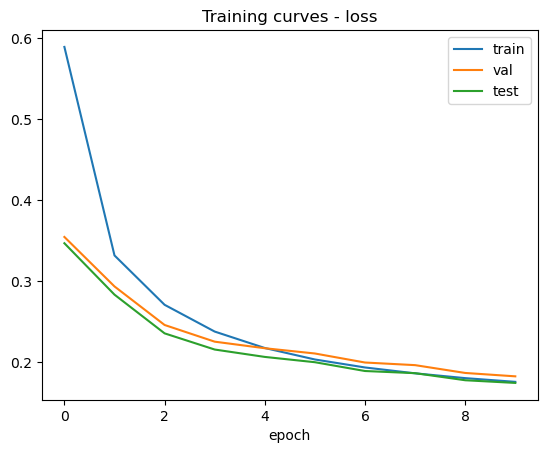

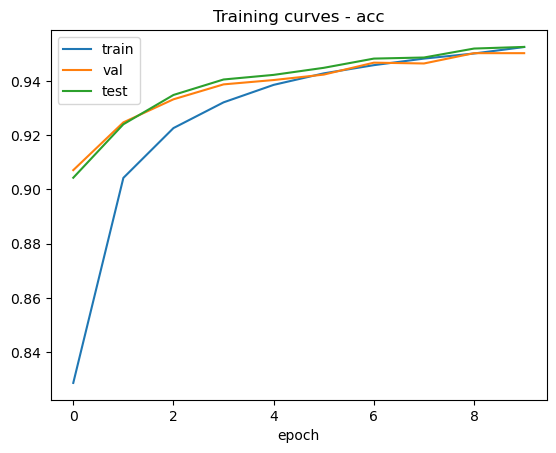

In [42]:
plot_training_curves(training_curves, phases=['train', 'val', 'test'])

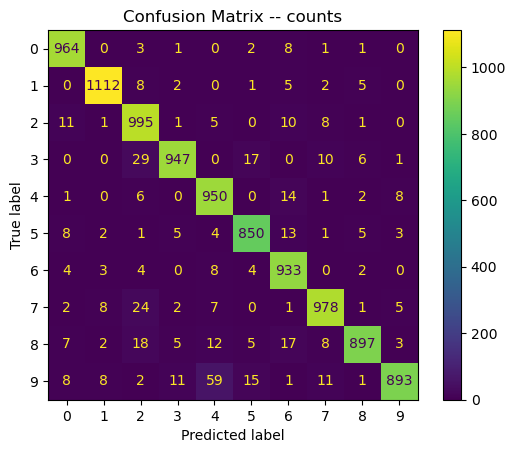

In [43]:
res = plot_cm(modelo, device, dataloaders, phase='test')